# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from PIL import Image

from sklearn import datasets
import tensorflow as tf

In [2]:
train_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
train_images = Path(r'../input/arabic-hwr-ai-pro-intake1/train')
## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_images.glob(r'*.png'))), name='Filepath').astype(str)
# train_images_paths.head()

# Explore the data

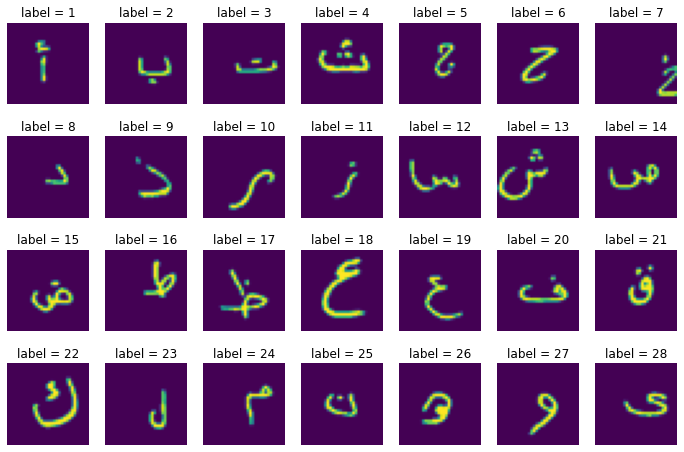

In [3]:
import collections

img_key_value = {}

for value in train_labels['label'].unique():
    img_key_value[value] = train_labels[train_labels['label']==value].index[0]
od = collections.OrderedDict(sorted(img_key_value.items()))
img_key_value = dict(od)


img_index = list(img_key_value.values())
img_label = list(img_key_value.keys())

fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}')
        img = plt.imread(train_images_paths.iloc[img_index[i]])
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [4]:
print('Number of Instances in train_set =>', len(train_images_paths))
print('Number of Instances in train_labels =>', len(train_labels))

print()

img = plt.imread(train_images_paths.iloc[img_index[0]])
print('shape of each Image is =>', img.shape)

Number of Instances in train_set => 13440
Number of Instances in train_labels => 13440

shape of each Image is => (32, 32, 4)


# Data Preprocessing

In [5]:
train_full_labels = train_labels['label'].values
train_full_set = np.empty((13440, 32, 32, 1), dtype=np.float32)  #take only the first 3 or 1 channels (13440, 32, 32, 3)

for idx, path in enumerate(train_images_paths):
#     img = plt.imread(path)
#     img = img[:,:,:3]
    img = Image.open(path)
    img = img.convert('L')
    img = np.array(img).reshape(32,32,1)
    train_full_set[idx] = img
    
print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)

train_full_set.shape => (13440, 32, 32, 1)
train_full_labels.shape => (13440,)


# Split the data

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_full_set, train_full_labels, 
                                                      test_size=0.1, shuffle=True, random_state=42)

print('X_train.shape =>', X_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_train.shape =>', y_train.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (12096, 32, 32, 1)
X_valid.shape => (1344, 32, 32, 1)
y_train.shape => (12096,)
y_valid.shape => (1344,)


# Model

In [7]:
model = tf.keras.models.Sequential()
# model.add( tf.keras.layers.Conv2D( filters = 6, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(32, 32, 1) ) )
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D( filters = 64, kernel_size=(3,3), activation='relu', padding='Same' ,input_shape=(32, 32, 1)) )
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(tf.keras.layers.Conv2D(filters = 96, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))



model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=512, activation='relu'))

model.add(tf.keras.layers.Dense(units=140, activation='relu'))

model.add(tf.keras.layers.Dense(units=28, activation = 'softmax'))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [8]:
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 96)        55392     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         110720    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [9]:
history = model.fit(X_train, y_train - 1, validation_data=(X_valid, y_valid - 1), 
                    epochs=100, batch_size=128, callbacks=[early_stopp])

2021-11-07 19:04:47.786685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
95/95 [==============================] - 21s 213ms/step - loss: 2.9368 - accuracy: 0.3290 - val_loss: 1.1379 - val_accuracy: 0.6466
Epoch 2/100
95/95 [==============================] - 19s 203ms/step - loss: 0.7533 - accuracy: 0.7509 - val_loss: 0.6154 - val_accuracy: 0.8036
Epoch 3/100
95/95 [==============================] - 20s 211ms/step - loss: 0.4015 - accuracy: 0.8679 - val_loss: 0.4557 - val_accuracy: 0.8497
Epoch 4/100
95/95 [==============================] - 20s 208ms/step - loss: 0.2708 - accuracy: 0.9088 - val_loss: 0.3708 - val_accuracy: 0.8876
Epoch 5/100
95/95 [==============================] - 19s 204ms/step - loss: 0.2109 - accuracy: 0.9277 - val_loss: 0.3136 - val_accuracy: 0.9010
Epoch 6/100
95/95 [==============================] - 20s 210ms/step - loss: 0.1351 - accuracy: 0.9553 - val_loss: 0.3161 - val_accuracy: 0.9048
Epoch 7/100
95/95 [==============================] - 19s 205ms/step - loss: 0.1076 - accuracy: 0.9643 - val_loss: 0.3376 - val_accuracy:

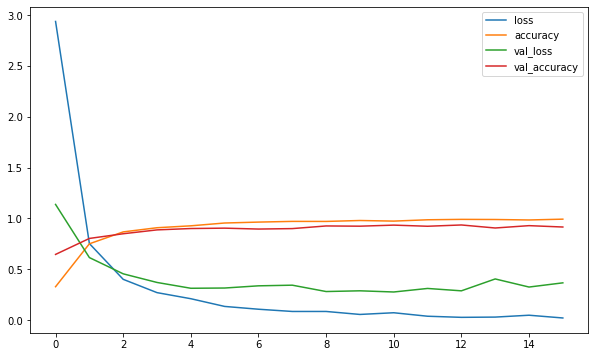

In [10]:
pd.DataFrame(history.history).plot(figsize=(10, 6));

In [11]:
loss_all_data, acc_all_data = model.evaluate(train_full_set, train_full_labels-1, verbose=0)
print('loss_all_data =>', loss_all_data)
print('acc_all_data =>', acc_all_data)

loss_all_data => 0.06317784637212753
acc_all_data => 0.9815475940704346


# Evaluation on Testing data

In [12]:
test_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')
test_images = Path(r'../input/arabic-hwr-ai-pro-intake1/test')

## read these all training images paths as Series
test_images_paths = pd.Series(sorted(list(test_images.glob(r'*.png'))), name='Filepath').astype(str)

test_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/test/00000.png
1    ../input/arabic-hwr-ai-pro-intake1/test/00001.png
2    ../input/arabic-hwr-ai-pro-intake1/test/00002.png
3    ../input/arabic-hwr-ai-pro-intake1/test/00003.png
4    ../input/arabic-hwr-ai-pro-intake1/test/00004.png
Name: Filepath, dtype: object

In [13]:
test_full_set = np.empty((3360, 32, 32, 1), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(test_images_paths):

    img = Image.open(path)

    img = img.convert('L')
    img = np.array(img).reshape(32,32,1)

#     img = plt.imread(path)
    
#     img = img[:,:,:3]
    test_full_set[idx] = img
    
print('test_full_set.shape =>', test_full_set.shape)

test_full_set.shape => (3360, 32, 32, 1)


In [14]:
y_preds_classes = np.argmax(model.predict(test_full_set), axis=-1)

In [15]:
test_labels['label'] = y_preds_classes +1

In [16]:
test_labels['label'].unique()

array([26, 10,  1, 15, 14, 23, 27, 18, 17,  9, 11, 25, 12, 20,  7,  4, 13,
        8,  5, 24, 16,  6,  2, 21,  3, 28, 19, 22])

In [17]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)